In [1]:
import datetime

import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv").sample(n=100, random_state=42)
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

df["value"] = np.log1p(df["value"])

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="timestamp"
)
train_data.head()

,,value
item_id,timestamp,
FOODS_3_180_CA_1,2011-01-29,0.000000
HOUSEHOLD_2_383_CA_3,2011-01-29,1.098612
FOODS_3_409_CA_3,2011-01-29,0.000000
FOODS_1_097_CA_2,2011-01-29,0.000000
HOBBIES_1_272_TX_2,2011-01-29,0.000000


In [3]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    path="autogluon-m5-daily",
    target="value",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
);

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/rsmith/PycharmProjects/time-series-llm/autogluon-m5-daily'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Dec 13 05:06:24 UTC 2025
CPU Count:          8
Pytorch Version:    2.7.1+cu118
CUDA Version:       11.8
GPU Memory:         GPU 0: 1.96/1.96 GB
Total GPU Memory:   Free: 1.96 GB, Allocated: 0.00 GB, Total: 1.96 GB
GPU Count:          1
Memory Avail:       6.82 GB / 15.47 GB (44.1%)
Disk Space Avail:   353.31 GB / 474.34 GB (74.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 'auto',
 'prediction_length': 28,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'ref

In [4]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.244440,6.835448,2.890046,10
1,TemporalFusionTransformer,-1.247539,0.269794,138.381240,8
2,Chronos2,-1.269141,6.561798,19.381478,5
3,ChronosWithRegressor[bolt_small],-1.281251,1.931327,2.719087,7
4,DeepAR,-1.315436,1.707849,140.394107,9
5,AutoETS,-1.519868,11.154883,13.365843,6
6,DynamicOptimizedTheta,-1.527021,16.107295,17.093892,4
7,DirectTabular,-1.672013,0.792389,6.096404,3
8,RecursiveTabular,-1.699350,0.663516,56.811842,2
9,SeasonalNaive,-1.700856,0.376816,5.026372,1


In [5]:
predictions = predictor.predict(train_data)
predictions[predictions < 0.0] = 0.0
predictions = np.expm1(predictions)
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean  0.1       0.2       0.3       0.4  \
item_id            timestamp                                                 
FOODS_3_180_CA_1   2016-04-25  0.007150  0.0  0.007257  0.004882  0.004786   
                   2016-04-26  0.007915  0.0  0.006637  0.003487  0.006167   
                   2016-04-27  0.008206  0.0  0.005727  0.003464  0.007187   
                   2016-04-28  0.008192  0.0  0.004830  0.003460  0.007936   
                   2016-04-29  0.008407  0.0  0.004673  0.003840  0.008632   
...                                 ...  ...       ...       ...       ...   
HOBBIES_1_315_WI_1 2016-05-18  0.002639  0.0  0.000367  0.004293  0.004555   
                   2016-05-19  0.002135  0.0  0.000000  0.004005  0.004454   
                   2016-05-20  0.001600  0.0  0.000000  0.003879  0.004092   
                   2016-05-21  0.001821  0.0  0.000499  0.003896  0.003573   
                   2016-05-22  0.002839  0.0  0.002045  0.004505  0.003215   

                                    0.5       0.6       0.7       0.8  \
item_id            timestamp                                            
FOODS_3_180_CA_1   2016-04-25  0.007150  0.021583  0.093194  0.748315   
                   2016-04-26  0.007915  0.016367  0.086292  0.741126   
                   2016-04-27  0.008206  0.013640  0.084047  0.745659   
                   2016-04-28  0.008192  0.011761  0.086774  0.761017   
                   2016-04-29  0.008407  0.011586  0.095296  0.772709   
...                                 ...       ...       ...       ...   
HOBBIES_1_315_WI_1 2016-05-18  0.002639  0.007440  0.000000  0.164638   
                   2016-05-19  0.002135  0.006471  0.000000  0.164865   
                   2016-05-20  0.001600  0.005802  0.000000  0.171819   
                   2016-05-21  0.001821  0.006922  0.000000  0.186810   
                   2016-05-22  0.002839  0.010109  0.003648  0.210648   

                                    0.9  
item_id            timestamp             
FOODS_3_180_CA_1   2016-04-25  1.319600  
                   2016-04-26  1.316417  
                   2016-04-27  1.337979  
                   2016-04-28  1.364922  
                   2016-04-29  1.363656  
...                                 ...  
HOBBIES_1_315_WI_1 2016-05-18  0.935896  
                   2016-05-19  0.944420  
                   2016-05-20  0.951268  
                   2016-05-21  0.970277  
                   2016-05-22  0.981907  

[2800 rows x 10 columns]

In [6]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]]
test_df = test_df.melt(id_vars="id", var_name="timestamp", value_name="value")

test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(
    lambda x: datetime.datetime(2011, 1, 28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="timestamp"
)
test_data

,,value
item_id,timestamp,
HOBBIES_1_100_CA_1,2011-01-29,1
HOBBIES_1_287_CA_1,2011-01-29,0
HOUSEHOLD_1_202_CA_1,2011-01-29,0
HOUSEHOLD_1_468_CA_1,2011-01-29,3
HOUSEHOLD_1_537_CA_1,2011-01-29,3
...,...,...
HOUSEHOLD_2_209_WI_3,2016-05-22,1
FOODS_2_127_WI_3,2016-05-22,0
FOODS_2_212_WI_3,2016-05-22,2


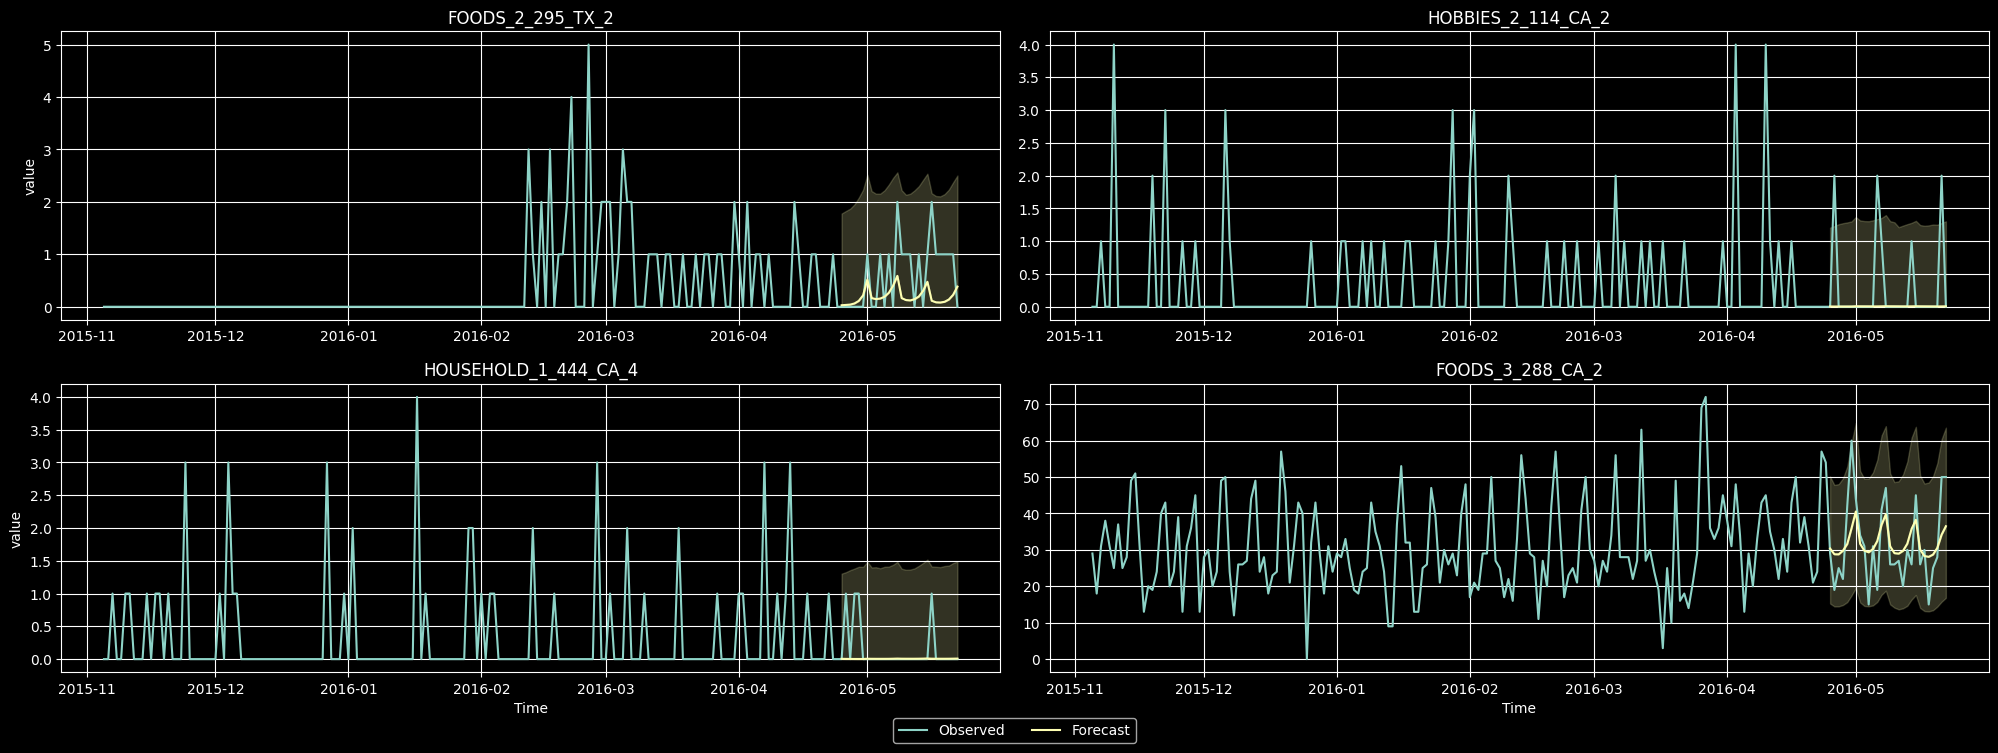

In [7]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);